# Choropleth Map with Time Slider

In [1]:
import pandas as pd
from sodapy import Socrata
from config import API_Key, username, password
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import re, datetime
import os
import folium
import json
print(folium.__version__)
import geopandas as gdp

0.8.3


## 1. Load and clean data from API

In [2]:
# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cityofnewyork.us", API_Key, username, password)

# Returned as JSON from API by sodapy.
data = client.get("43nn-pn8j",limit=381912)

In [3]:
# Convert to dataframe
data_df = pd.DataFrame.from_records(data)
data_df.score = data_df.score.astype(float)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381912 entries, 0 to 381911
Data columns (total 18 columns):
action                   381230 non-null object
boro                     381912 non-null object
building                 381691 non-null object
camis                    381912 non-null object
critical_flag            381912 non-null object
cuisine_description      381912 non-null object
dba                      381701 non-null object
grade                    192655 non-null object
grade_date               190370 non-null object
inspection_date          381912 non-null object
inspection_type          381230 non-null object
phone                    381903 non-null object
record_date              381912 non-null object
score                    364453 non-null float64
street                   381912 non-null object
violation_code           376768 non-null object
violation_description    374047 non-null object
zipcode                  376396 non-null object
dtypes: float64(1), obje

In [4]:
data_df['inspection_date'] = data_df['inspection_date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%f').year)
data_df['inspection_date'].head()

0    2018
1    2018
2    2017
3    2017
4    2016
Name: inspection_date, dtype: int64

In [5]:
data_df.head()
ready_score = data_df.groupby(['inspection_date','zipcode'])['score'].mean().dropna()
ready_score = pd.DataFrame(ready_score).reset_index()
ready_score.zipcode = ready_score.zipcode.astype(float)
ready_score.head()

,inspection_date,zipcode,score
0,2011,11420.0,2.000000
1,2012,11420.0,7.000000
2,2013,10004.0,0.000000
3,2013,11205.0,4.000000
4,2013,11420.0,14.833333


## 2. Data preparation
- Get a geojson that contains all the features
- Prepare a dictionary in which the keys are the feature-ids with key-value pairs for color and opacity information
- Example of the dictionary format
<br>styledict = {
    '0': {
        '2017-1-1': {'color': 'ffffff', 'opacity': 1}
        '2017-1-2': {'color': 'fffff0', 'opacity': 1}
        ...
        },
    ...,
    'n': {
        '2017-1-1': {'color': 'ffffff', 'opacity': 1}
        '2017-1-2': {'color': 'fffff0', 'opacity': 1}
        ...
        }
}

### Find GeoJSON and load GeoJSON
- Source for GeoJSON of NYC: <br> http://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90?view_id=b34c6552-9fdb-4f95-8810-0588ad1a4cc8
- GeoJSON is needed to represent the boundaries of each zip code in NYC

In [6]:
# Load GeoJSON
with open('nyc-zipcode.geojson','r') as jsonFile:
    geo_data = json.load(jsonFile)
geojson_zip = geo_data

geojson_zip['features'][1]

{'type': 'Feature',
 'properties': {'OBJECTID': 2,
  'postalCode': '11004',
  'PO_NAME': 'Glen Oaks',
  'STATE': 'NY',
  'borough': 'Queens',
  'ST_FIPS': '36',
  'CTY_FIPS': '081',
  'BLDGpostal': 0,
  '@id': 'http://nyc.pediacities.com/Resource/PostalCode/11004',
  'longitude': -73.711608312,
  'latitude': 40.745365835},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-73.71132911125308, 40.74947450816085],
    [-73.7106837407401, 40.75004039450918],
    [-73.70869392379949, 40.74875836557177],
    [-73.70713084684176, 40.749582740537946],
    [-73.70419967936363, 40.750169552569766],
    [-73.70218528698231, 40.744741887753854],
    [-73.70308721830736, 40.744547257355144],
    [-73.70098278625547, 40.73889569923034],
    [-73.71371033246908, 40.736174704865455],
    [-73.714741836008, 40.73782936804115],
    [-73.71567895968894, 40.73962914915626],
    [-73.71867075939582, 40.74631499057428],
    [-73.71966142935703, 40.748945236431474],
    [-73.72082889049311, 40.75117302817

In [7]:
# Remove zip code not in our df
geozips = []
for i in range(len(geojson_zip['features'])):
    if geojson_zip['features'][i]['properties']['postalCode'] in list(ready_score['zipcode'].unique()):
        geozips.append(geojson_zip['features'][i])

# Create new json object
clean_json = dict.fromkeys(['type','features'])
clean_json['type'] = 'Feature'
clean_json['features'] = geozips

# Save clean json as clean-json
open("slider-clean-json.json", "w").write(
    json.dumps(clean_json, sort_keys=True, indent=4, separators=(',',': ')))

45

### Create appropriate data dictionary

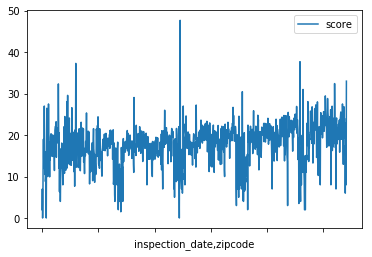

In [8]:
plot_ready_score = ready_score.groupby(["inspection_date","zipcode"])['score'].mean()
plot_ready_score = pd.DataFrame(plot_ready_score)
ax = plot_ready_score.plot()

In [9]:
plot_ready_score = plot_ready_score.reset_index()
plot_ready_score = plot_ready_score.set_index('inspection_date')
plot_ready_score.head()

,zipcode,score
inspection_date,,
2011,11420.0,2.000000
2012,11420.0,7.000000
2013,10004.0,0.000000
2013,11205.0,4.000000
2013,11420.0,14.833333


In [10]:
style_score = {str(zipcode): data.to_dict() for
    country, data in plot_ready_score.items()}

NameError: name 'zipcode' is not defined

## 4. Create folium maps

In [ ]:
from folium.plugins import TimeSliderChoropleth

## 6. Choropleth map with folium

In [ ]:
# table = main table/data frame we read from (pandas DataFrame)
# zips = column name where ZIP codes are (string)
# mapped_feature = column name for feature we want to visualize (string)
# add_text = any additional commentary to be added in the map legend (string)

def create_map(table, zips, mapped_feature, color = 'RdYlGn', add_text = ''):
    nyc_geo = r'clean-json.json'
    m = folium.Map(location = [40.730610, -73.935242],
                   tiles='Mapbox Bright')
    folium.Choropleth(
        geo_data = nyc_geo, data = table,
        key_on = 'feature.properties.postalCode',
        columns = [zips, mapped_feature],
        fill_color = color, fill_opacity = 0.7, line_opacity = 0.2,
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' Across NYC'
    ).add_to(m)
    m.add_child(folium.LatLngPopup())
    folium.LayerControl().add_to(m)
    m.save(outfile = mapped_feature + '_map.html')
    return m

In [ ]:
create_map(score_map, 'zipcode', 'avg_score', add_text='of Restaurants')

In [ ]:
create_map(score_map, 'zipcode', 'total_restaurants', 'BuPu')


In [ ]:
nyc_geo = r'clean-json.json'
m = folium.Map(location = [40.730610, -73.935242],
                   tiles='Mapbox Bright')
folium.Choropleth(
        geo_data = nyc_geo, data = score_map,
        key_on = 'feature.properties.postalCode',
        columns = ['zipcode', 'avg_score'],
        fill_color = 'RdYlGn', fill_opacity = 0.7, line_opacity = 0.2,
        legend_name = (' ').join('avg_score'.split('_')).title() + ' ' + 'of Restaurants' + ' Across NYC'
    ).add_to(m)
m.add_child(folium.LatLngPopup())
folium.LayerControl().add_to(m)
#m.save(outfile = mapped_feature + '_map.html')
m